## prove xgboost can overfit this problem

## prove simple nn can overfit this problem

### The conclusion of this experiment is that the embeddings from the pretrained model significantly distinguish differences


In [1]:
import os
import torch

In [2]:
image_folder_path = (
    "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data/full_image"
)
image_name_list = os.listdir(image_folder_path)
image_name_list.sort()
image_name_list = [
    image_name for image_name in image_name_list if not image_name.startswith(".")
]
image_path_list = [
    os.path.join(image_folder_path, image_name) for image_name in image_name_list
]

In [3]:
import pandas as pd

data_path = (
    "/Users/user/Documents/Coding/cro_location_intelligence/notebook/7 BE for Ford.xlsx"
)
df_dict = pd.read_excel(data_path, sheet_name=None)
store_id_list = df_dict["Train"]["store_id"].tolist()
store_id_list += df_dict["Test2022"]["store_id"].tolist()
store_id_list = [str(i) for i in store_id_list]
print(len(store_id_list))
print(store_id_list[:5])

1066
['1025', '8396', '8572', '1058', '1095']


In [4]:
store_id_we_have = []
for image_name in image_name_list:
    store_id_we_have.append(image_name.split(".")[0])
print(len(store_id_we_have))
print(store_id_we_have[:5])

9997
['10', '100', '1000', '10000', '10001']


In [5]:
store_id_we_dont_have = []
for id in store_id_list:
    if id not in store_id_we_have:
        print(id)
        store_id_we_dont_have.append(id)

print(len(store_id_we_dont_have))

4926
5350
5651
6034
6298
9143
9295
9364
9381
9385
9454
11022
11185
11397
11413
12007
13099
13218
13947
14422
17542
21


In [6]:
len(store_id_list)

1066

In [10]:
# feed model net
from urllib.request import urlopen
from PIL import Image
import timm
from tqdm import tqdm

# new_df_path = "/Users/user/Documents/Coding/cro_location_intelligence/notebook/7 lat long with embedding.csv"
new_df_path = "/Users/user/Documents/Coding/cro_location_intelligence/src/data/all_data_embedding.csv"
if not os.path.exists(new_df_path):
    # img = Image.open(urlopen(
    #     'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
    # ))
    # img = image_1
    output_dict = {}
    model = timm.create_model(
        "maxvit_tiny_tf_512.in1k",
        pretrained=True,
        num_classes=0,  # remove classifier nn.Linear
    )
    model = model.eval()
    data_config = timm.data.resolve_model_data_config(model)
    transforms = timm.data.create_transform(**data_config, is_training=False)

    # for image_name in image_name_list:
    batch_size = 4
    # check is file exist

    check_store_id_list = []
    for store_id in store_id_list:
        image_name = store_id + ".png"
        image_path = os.path.join(image_folder_path, image_name)
        if os.path.exists(image_path):
            check_store_id_list.append(store_id)
    store_id_list = check_store_id_list
    print("len(store_id_list)", len(store_id_list))
    # Iterate through store_ids in batches
    for batch_start in tqdm(
        range(0, len(store_id_list), batch_size), desc="store_id batches"
    ):
        batch_store_ids = store_id_list[batch_start : batch_start + batch_size]
        batch_images = []

        # Load and preprocess images in the current batch
        for store_id in batch_store_ids:
            image_name = store_id + ".png"
            image_path = os.path.join(image_folder_path, image_name)
            img = Image.open(image_path).convert("RGB")
            batch_images.append(transforms(img))

        # Stack images to create a batch
        batch_images = torch.stack(batch_images)

        # Forward pass for the batch
        with torch.no_grad():
            output = model.forward_features(batch_images)
            output = model.forward_head(output, pre_logits=True)

        # Store results in output_dict
        for i, store_id in enumerate(batch_store_ids):
            output_dict[store_id] = output.detach().numpy()[i]
        # output is a (1, num_features) shaped tensor

len(store_id_list) 1045


store_id batches: 100%|██████████| 262/262 [11:22<00:00,  2.60s/it]


In [11]:
import numpy as np

r = 2
circle_area = np.pi * r**2
square_area = (2 * r) ** 2
circle_area, square_area, circle_area / square_area

(12.566370614359172, 16, 0.7853981633974483)

In [12]:
# rename columns by add prefix "embedding_"

In [14]:
# merge 2 df by index
import pandas as pd

# convert output_dict to dataframe
if os.path.exists(new_df_path) is False:
    output_df = pd.DataFrame.from_dict(output_dict, orient="index")
    output_df.head()
    output_df.columns = ["embedding_" + str(col + 1) for col in output_df.columns]
    # convert output_df store_id to int
    output_df["store_id"] = output_df.index
    output_df.store_id = output_df.store_id.astype(int)
    data_path = (
        "/Users/user/Documents/Coding/cro_location_intelligence/src/data/all_data.csv"
    )
    df = pd.read_csv(data_path)
    # merge df with output_df with columns store_id
    df = pd.merge(df, output_df, on="store_id", how="inner")

    # df = pd.concat([df, output_df], axis=1)
    df.to_csv(new_df_path, index=False)

In [15]:
df.head()

,store_id,sum_pop_in_voronoi,voronoi_area,voronoi_density,cro_open_year,CRO_store_length,CRO_store_parking,CRO_store_stock_area,CRO_store_total_area,CRO_store_width,...,embedding_503,embedding_504,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511,embedding_512
0,1025.0,16369.32,38412.2,0.426149,16.0,20.00,0.0,97.39,274.39,14.00,...,0.618719,0.397206,0.539024,0.034935,-0.425025,-0.202426,-0.603762,-0.113011,0.282425,-0.264580
1,8396.0,15736.69,241705.5,0.065107,16.0,15.35,0.0,44.86,175.86,19.80,...,0.853443,0.604886,0.487524,0.250037,-0.343431,0.215231,-0.492256,-0.528084,-0.124986,-0.288903
2,8572.0,16156.14,193980.1,0.083288,16.0,9.85,0.0,12.90,145.90,17.80,...,0.461060,0.396897,0.465704,0.372753,0.014367,0.028150,-0.261129,-0.084676,-0.178961,0.154477
3,1058.0,11213.96,77343.2,0.144990,16.0,13.94,0.0,11.83,93.83,7.90,...,0.755208,0.682671,0.673349,-0.079623,-0.562957,-0.830060,-0.801435,-0.366279,0.880094,0.253283
4,1095.0,16216.47,90980.3,0.178242,16.0,15.82,0.0,35.18,113.18,7.94,...,0.432766,0.767998,0.388810,0.492982,0.151838,-0.086584,-0.651078,-0.546258,-0.215056,-0.015719


In [16]:
# save df

In [23]:
# use embedding to predict mockup_sale with xgboost
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np

# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

# get all column has embedding_ prefix
feature_columns = [col for col in df.columns if col.startswith("embedding_")]
feature_columns += ["subset"]
feature_columns += ["y_nor"]
# assign to x
all_data = df[feature_columns]

# create train test with columns subset
x_train = all_data[all_data.subset == "train"]
x_train = x_train.drop(columns=["subset"])
y_train = x_train["y_nor"]
x_test = all_data[all_data.subset == "test"]
x_test = x_test.drop(columns=["subset"])
y_test = x_test["y_nor"]
x_train = x_train.drop(columns=["y_nor"])
x_test = x_test.drop(columns=["y_nor"])

In [24]:
x_train.shape, y_train.shape

((977, 512), (977,))

In [20]:
import matplotlib.pyplot as plt

mean_absolute_percentage_error: 1.3588517235583804


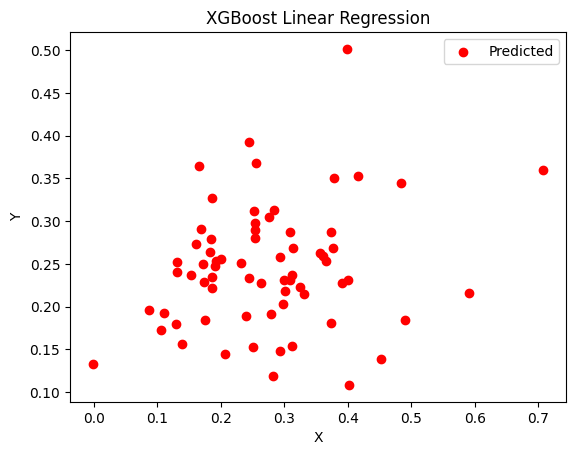

In [25]:
# Create an XGBoost regressor
regressor = xgb.XGBRegressor(objective="reg:squarederror", seed=42)

# Train the model
regressor.fit(x_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(x_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"mean_absolute_percentage_error: {mape}")

# Plot the results
# plt.scatter(x_test, y_test, color="black", label="Actual")
plt.scatter(y_test, y_pred, color="red", label="Predicted")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("XGBoost Linear Regression")
plt.legend()
plt.show()

In [27]:
from typing import Any
from lightning.pytorch.utilities.types import STEP_OUTPUT
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import lightning as pl

from lightning.pytorch.loggers import TensorBoardLogger


# Define a simple dataset
class PriceDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Define a simple feedforward neural network
class PricePredictor(pl.LightningModule):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.training_step_loss = []

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.MSELoss()(y_pred.flatten(), y)
        self.training_step_loss.append(loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.01)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.MSELoss()(y_pred.flatten(), y)
        self.log("test_loss", loss)

    def on_train_epoch_end(self):
        # print("\n\tself.training_step_loss", self.training_step_loss)
        # print("\n\tself.training_step_loss", self.training_step_loss[0].shape)
        # print("\n\tself.training_step_loss", self.training_step_loss[0])
        # print()
        # avg_loss = torch.stack([x["loss"] for x in self.training_step_loss]).mean()
        avg_loss = torch.stack(
            [x.detach().cpu() for x in self.training_step_loss]
        ).mean()
        self.log("train_loss", avg_loss.item(), on_epoch=True)


# Generate some random data for demonstration purposes
np.random.seed(42)
# features = np.random.rand(100, 512, 1)  # 100 samples with 512x1 features each
# labels = (
#     3 * features[:, 0, 0]
#     + 2 * features[:, 1, 0]
#     + 1.5 * features[:, 2, 0]
#     + 1
#     + 0.1 * np.random.randn(100)
# )

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     x, y, test_size=0.2, random_state=42
# )
X_train = np.array(x_train)
X_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
# Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(-1, 512, 1)
# X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(-1, 512, 1)
# y_train = np.array(y_train)
# Create data loaders
train_dataset = PriceDataset(X_train, y_train)
test_dataset = PriceDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize the model
input_size = X_train.shape[1:]
model = PricePredictor(input_size[0])

# Initialize a PyTorch Lightning Trainer
logger = TensorBoardLogger("tb_logs", name="my_model")

trainer = pl.Trainer(max_epochs=250, logger=logger)

# Train the model
trainer.fit(model, train_loader)

# Test the model
trainer.test(dataloaders=test_loader)

# Make predictions
model.eval()
with torch.no_grad():
    example_input = torch.tensor(X_test[:5], dtype=torch.float32)
    predictions = model(example_input).flatten().numpy()

print("Example Predictions:", predictions)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 131 K 
1 | fc2  | Linear | 32.9 K
2 | fc3  | Linear | 8.3 K 
3 | fc4  | Linear | 65    
--------------------------------
172 K     Trainable params
0         Non-trainable params
172 K     Total params
0.690     Total estimated model params size (MB)
/Users/user/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/Users/user/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/Users/user/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at tb_logs/my_model/version_24/checkpoints/epoch=85-step=10578.ckpt
Loaded model weights from the checkpoint at tb_logs/my_model/version_24/checkpoints/epoch=85-step=10578.ckpt
/Users/user/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.026511339470744133    │
└───────────────────────────┴───────────────────────────┘

Example Predictions: [0.21888998 0.40720308 0.48611677 0.21867399 0.38498384]


In [32]:
number_predict = 100
with torch.no_grad():
    example_input = torch.tensor(X_test[:number_predict], dtype=torch.float32)
    predictions = model(example_input).flatten().numpy()
    # predictions = [int(round(pred)) for pred in predictions]

print("Example Predictions:", predictions)
print("Ground Truth:", y_test[:number_predict])

Example Predictions: [0.21888998 0.40720314 0.48611677 0.21867399 0.38498384 0.36464393
 0.35445923 0.40523118 0.21002647 0.44709498 0.2101983  0.3464612
 0.21002647 0.21002647 0.26941204 0.5750031  0.5600202  0.21002647
 0.21002647 0.21002647 0.33551276 0.51747394 0.21002647 0.3014243
 0.21002647 0.5491209  0.21002647 0.37121096 0.33016297 0.21002647
 0.24187025 0.25370324 0.21002647 0.51552844 0.43987876 0.3792712
 0.21002647 0.33326122 0.21002647 0.21002647 0.23272696 0.24878214
 0.21002647 0.44236976 0.34191605 0.32440567 0.21002647 0.21002647
 0.25172803 0.28738374 0.22745976 0.22685295 0.26788747 0.21002647
 0.21002647 0.24618287 0.23377493 0.41793457 0.36582476 0.21002647
 0.2972245  0.21002647 0.21002647 0.21002647 0.53769374 0.21002647
 0.44904956 0.21002647]
Ground Truth: [ 0.70841744  0.25344402  0.16957017  0.26360735  0.27926378  0.24470932
  0.17560358  0.36602374  0.16146888  0.27521046  0.49095872  0.28146068
  0.48453337  0.08721828  0.30963766  0.30938209  0.35643737 

In [35]:
result_df = pd.DataFrame({"y_pred": predictions, "y_test": y_test[:number_predict]})
result_df.head()

,y_pred,y_test
0,0.218890,0.708417
1,0.407203,0.253444
2,0.486117,0.169570
3,0.218674,0.263607
4,0.384984,0.279264


In [36]:
# cal mape each row
def cal_mape(row):
    return abs(row.y_pred - row.y_test) / row.y_test


result_df["mape"] = result_df.apply(cal_mape, axis=1)
result_df.head()

,y_pred,y_test,mape
0,0.218890,0.708417,0.691016
1,0.407203,0.253444,0.606679
2,0.486117,0.169570,1.866759
3,0.218674,0.263607,0.170456
4,0.384984,0.279264,0.378567


In [39]:
# count mape < 0.15
print(result_df[result_df.mape < 0.15].shape[0])
result_df[result_df.mape < 0.15].shape[0] / result_df.shape[0]

11


0.16176470588235295

In [29]:
y_test[:5]

array([0.70841744, 0.25344402, 0.16957017, 0.26360735, 0.27926378])

In [40]:
number_predict = 10000
with torch.no_grad():
    example_input = torch.tensor(X_train[:number_predict], dtype=torch.float32)
    predictions = model(example_input).flatten().numpy()
    # predictions = [int(round(pred)) for pred in predictions]

# print("Example Predictions:", predictions)
# print("Ground Truth:", y_train[:number_predict])

In [41]:
result_df = pd.DataFrame({"y_pred": predictions, "y_train": y_train[:number_predict]})
result_df.head()

,y_pred,y_train
0,0.210026,0.226238
1,0.210026,0.182798
2,0.228925,0.433002
3,0.466621,0.221966
4,0.210026,0.149573


In [43]:
# cal mape each row
def cal_mape(row):
    try:
        return abs(row.y_pred - row.y_train) / row.y_train
    except:
        return abs(row.y_pred - row.y_test) / row.y_test


result_df["mape"] = result_df.apply(cal_mape, axis=1)
result_df.head()

/var/folders/9g/3rr3k99j0td2974k71sy46_h0000gp/T/ipykernel_49165/724403404.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return abs(row.y_pred - row.y_train) / row.y_train


,y_pred,y_train,mape
0,0.210026,0.226238,0.071656
1,0.210026,0.182798,0.148951
2,0.228925,0.433002,0.471306
3,0.466621,0.221966,1.102214
4,0.210026,0.149573,0.404174


In [45]:
print(result_df[result_df.mape < 0.15].shape[0])
result_df[result_df.mape < 0.15].shape[0] / result_df.shape[0]

228


0.23336745138178097